In [1]:
import uproot
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
def plot_histogram_from_file(filename):
    # Extract the section from the filename for the title
    section = filename.split('_')[2]
    section2_raw = filename.split('_')[3].rstrip('p')  # Removes the trailing 'p'
    
    # Load the tree
    file = uproot.open(f"/lustre19/expphy/volatile/halla/sbs/seeds/parse/{filename}")
    tree = file["P"]
        
    # Load the branches as arrays and create a DataFrame
    branches = tree.arrays(["dx", "nucleon", "mc_weight_norm", "fiducial_sig_x", "fiducial_sig_y"], library="pd")
    
    #print("Columns in DataFrame:", branches.columns)
    
    # Define custom binning within the range of -2 to 1
    bins = np.linspace(-2, 1, 200)
    bin_width = (bins[1] - bins[0]) / 2  # Calculate half the bin width
    
    # Apply cuts using query method on DataFrame
    branches = branches.query("fiducial_sig_y>3 and fiducial_sig_x>3")

    # After applying cuts, separate proton and neutron data based on the 'nucleon' condition
    dx_p_array = branches[branches['nucleon'] == 0]['dx']
    dx_n_array = branches[branches['nucleon'] == 1]['dx']
    weights_p_array = branches[branches['nucleon'] == 0]['mc_weight_norm']
    weights_n_array = branches[branches['nucleon'] == 1]['mc_weight_norm']

    # Calculate the integrals (weighted sums) and the number of events after cuts
    integral_p = weights_p_array.sum()
    integral_n = weights_n_array.sum()
    N_p = dx_p_array.size
    N_n = dx_n_array.size

    # Calculate the ratio of N_n to N_p
    ratio_n_p = integral_n / integral_p if integral_p else np.nan

    # Plotting
    plt.figure(figsize=(20, 12))
    
    # Concatenate dx_p_array and dx_n_array
    dx_array_combined = np.concatenate((dx_p_array, dx_n_array))

    # Now you can calculate the histogram using the combined array
    counts, edges = np.histogram(dx_array_combined, bins=bins, weights=np.concatenate((weights_p_array, weights_n_array)))

    # Shift edges to the right by half a bin width for plotting
    bin_width = np.diff(edges)[0] / 2  # More robust calculation of bin width
    shifted_edges = edges[:-1] + bin_width

    # Create histograms with weights after cuts
    plt.hist(dx_p_array, bins=bins, weights=weights_p_array, label=f'dx_p (proton) weighted, N={integral_p:.0f}', alpha=0.75)
    plt.hist(dx_n_array, bins=bins, weights=weights_n_array, label=f'dx_n (neutron) weighted, N={integral_n:.0f}', alpha=0.75)
        
    # Plot using plt.step for a histogram-like line plot
    plt.step(shifted_edges, counts, where='mid', color='black', linewidth=2, label=f'dx (sum) weighted')
    
    # Add a dummy plot for the ratio of N_n to N_p in the legend
    plt.plot([], [], ' ', label=f'Ratio of N_n to N_p: {ratio_n_p:.4f}')

    # Customize the plot
    plt.xlabel('dx', fontsize='xx-large')
    plt.ylabel('Counts', fontsize='xx-large')
    plt.title(f'Histograms of dx, dx_p, and dx_n with Weights and Cuts for {section} {section2_raw}', fontsize='xx-large')
    plt.xlim(-2, 1)
    plt.legend(fontsize='xx-large')
    plt.grid(True)
    plt.show()

In [2]:

def plot_histogram_from_file(filename):
    # Extract the section from the filename for the title
    section = filename.split('_')[2]
    section2_raw = filename.split('_')[3].rstrip('p')  # Removes the trailing 'p'
    
    # Efficient data loading
    with uproot.open(f"/lustre19/expphy/volatile/halla/sbs/seeds/parse/{filename}") as file:
        tree = file["P"]
        branches = tree.arrays(["dx", "hcale", "nucleon", "mc_weight_norm", "fiducial_sig_x", "fiducial_sig_y"], library="pd")
    
    # Apply cuts directly, minimizing DataFrame size early on
    #filtered_branches = branches[(branches['fiducial_sig_y'] > 0.001) & (branches['fiducial_sig_x'] > 0.001)]
    filtered_branches = branches[(branches['hcale'] > 0)]
    
    # Separate data for proton and neutron
    proton_cond = filtered_branches['nucleon'] == 0
    neutron_cond = filtered_branches['nucleon'] == 1

    dx_p = filtered_branches[proton_cond]['dx']
    dx_n = filtered_branches[neutron_cond]['dx']
    weights_p = filtered_branches[proton_cond]['mc_weight_norm']
    weights_n = filtered_branches[neutron_cond]['mc_weight_norm']

    # Calculate integrals (weighted sums) and number of events after cuts more efficiently
    integral_p = weights_p.sum()
    integral_n = weights_n.sum()

    # Calculate the ratio of N_n to N_p
    ratio_n_p = integral_n / integral_p if integral_p else np.nan

    # Plotting setup
    plt.figure(figsize=(20, 12))
    bins = np.linspace(-3, 2, 500)

    # Combined dx array for plotting
    dx_array_combined = np.concatenate((dx_p, dx_n))
    weights_combined = np.concatenate((weights_p, weights_n))

    # Calculate the histogram for the combined dx array
    counts, edges = np.histogram(dx_array_combined, bins=bins, weights=weights_combined)

    # Shift edges to the right by half a bin width for plotting
    bin_width = np.diff(edges)[0] / 2  # More robust calculation of bin width
    shifted_edges = edges[:-1] + bin_width

    # Plot histograms
    plt.hist(dx_p, bins=bins, weights=weights_p, label=f'dx_p (proton) weighted, N={integral_p:.0f}', alpha=0.75)
    plt.hist(dx_n, bins=bins, weights=weights_n, label=f'dx_n (neutron) weighted, N={integral_n:.0f}', alpha=0.75)

    # Use plt.step for the combined dx histogram with shifted edges
    plt.step(shifted_edges, counts, where='mid', color='black', linewidth=2, label=f'dx (sum) weighted')
    
    # Add a dummy plot for the ratio of N_n to N_p in the legend
    plt.plot([], [], ' ', label=f'Ratio of N_n to N_p: {ratio_n_p:.4f}')
    
    # Customize the plot
    plt.xlabel('dx', fontsize='xx-large')
    plt.ylabel('Counts', fontsize='xx-large')
    plt.title(f'Histograms of dx, dx_p, and dx_n with Weights and Cuts for {section} {section2_raw}', fontsize='xx-large')
    plt.xlim(-3, 2)
    plt.legend(fontsize='xx-large')
    plt.grid(True)
    plt.show()

In [5]:
# List of files
# List of files
files = [
    "parse_mc_sbs11_100p_barebones.root",
    "parse_mc_sbs14_70p_barebones.root",
    "parse_mc_sbs4_30p_barebones_alt.root",
    "parse_mc_sbs4_30p_barebones.root",
    "parse_mc_sbs4_50p_barebones.root",
    "parse_mc_sbs7_85p_barebones.root",
    "parse_mc_sbs8_70p_barebones.root",
    "parse_mc_sbs9_70p_barebones.root",
]

#files = [
#    "parse_mc_sbs4_50p_barebones.root",
#]

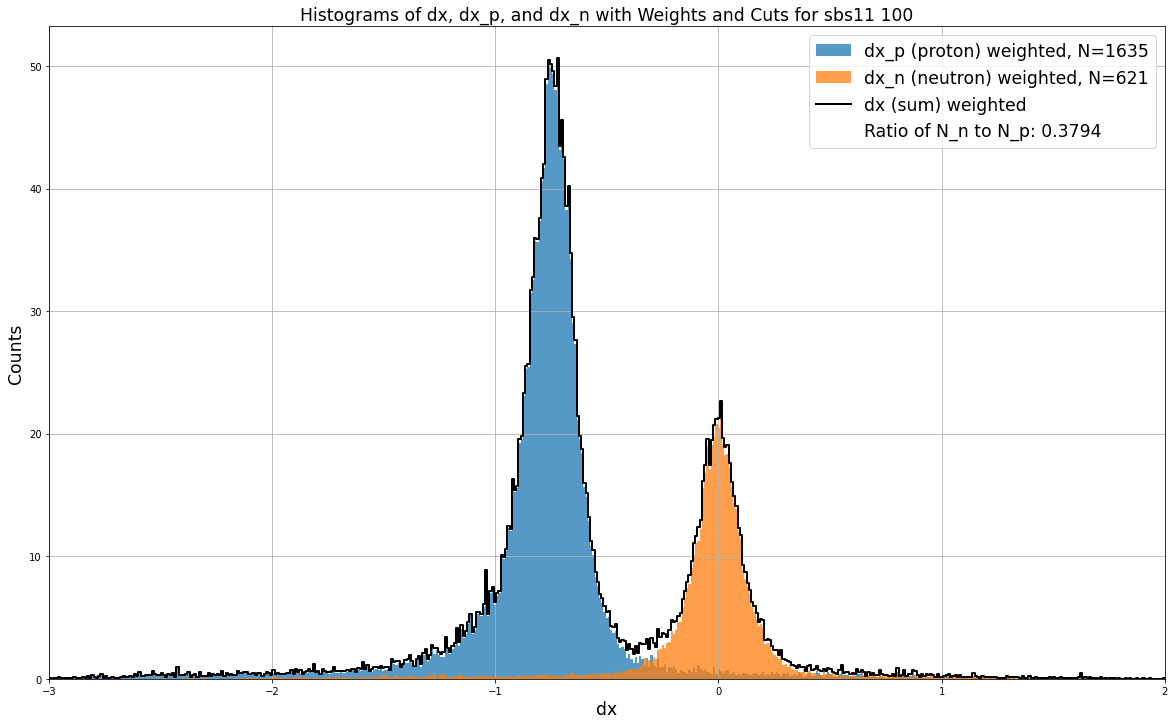

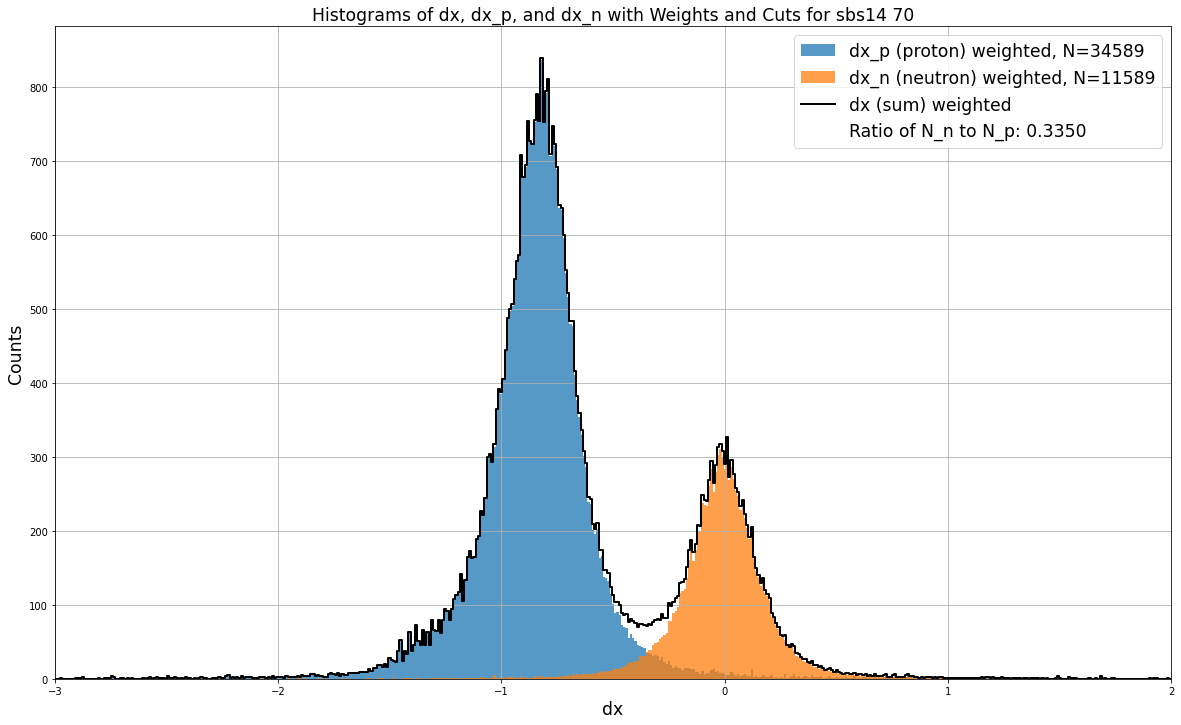

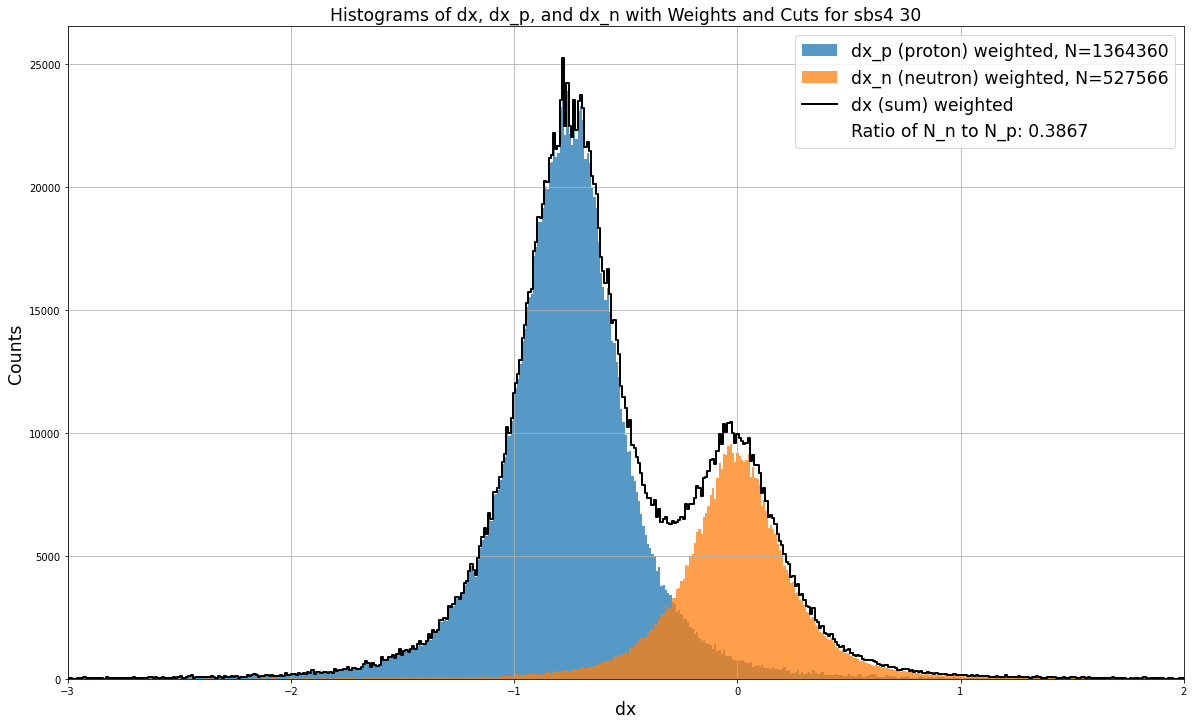

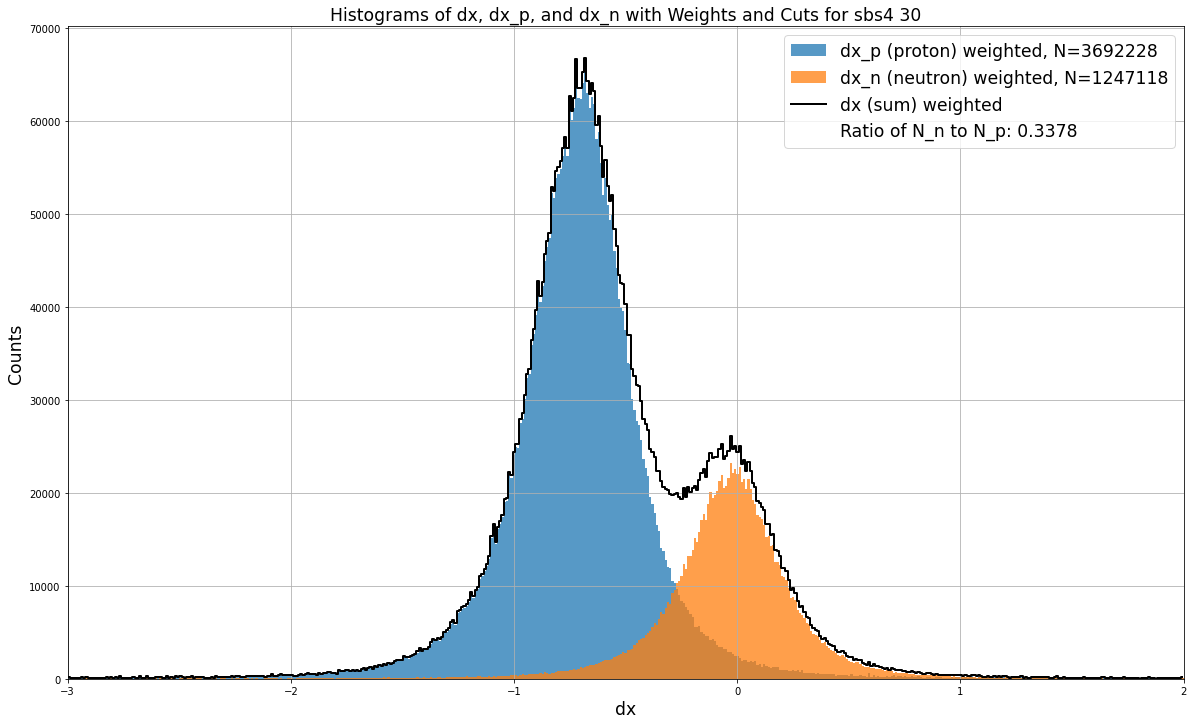

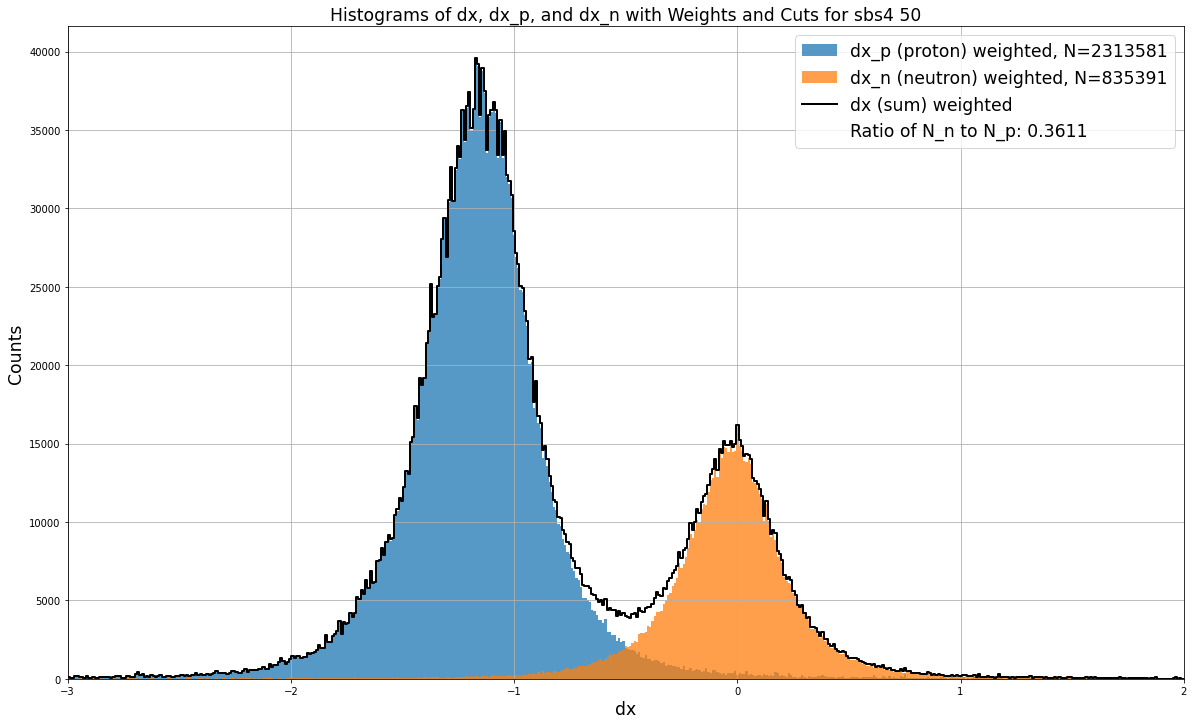

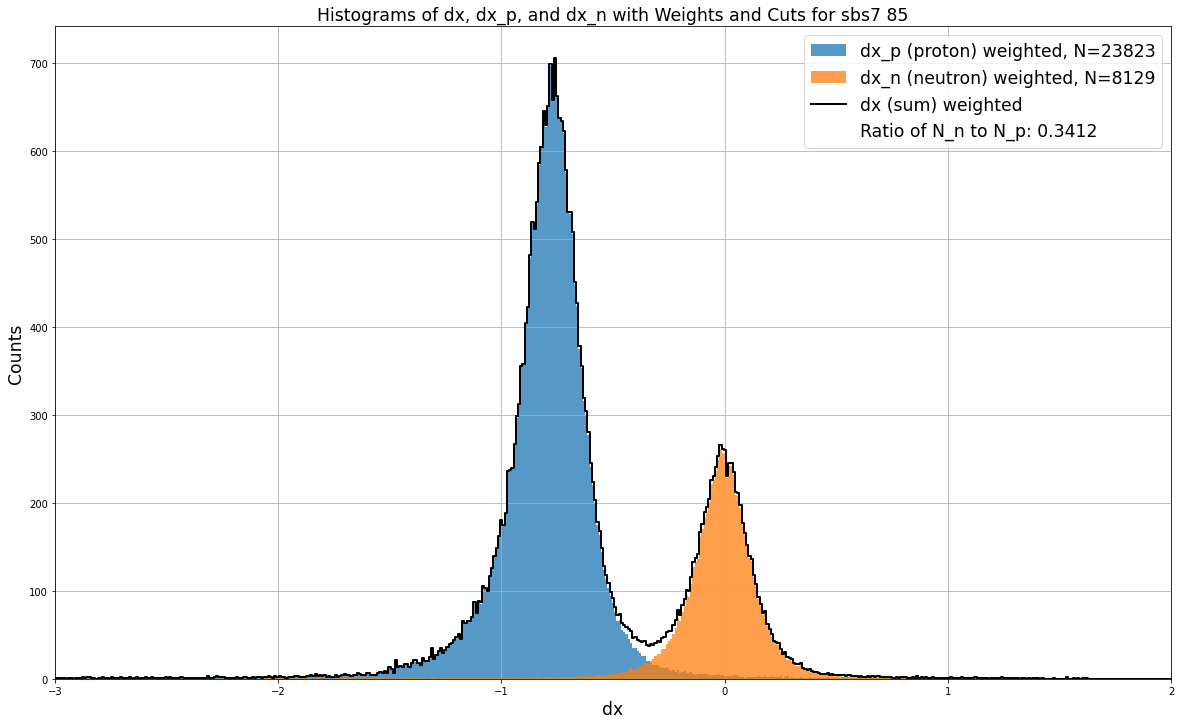

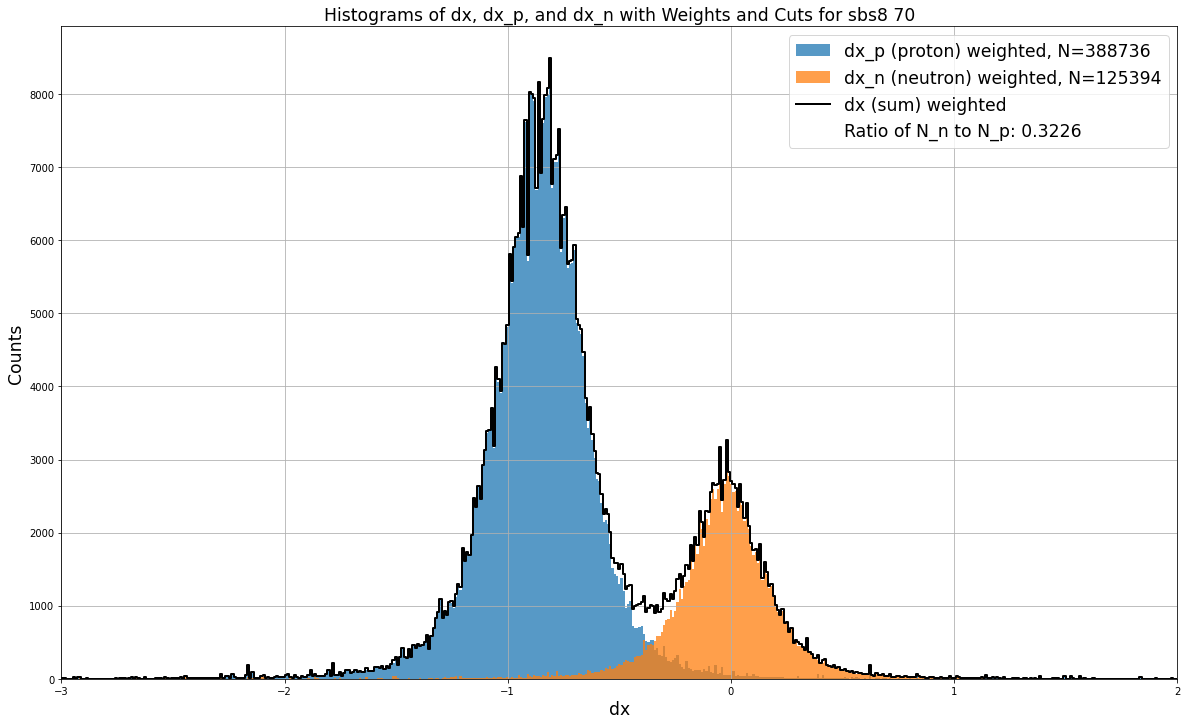

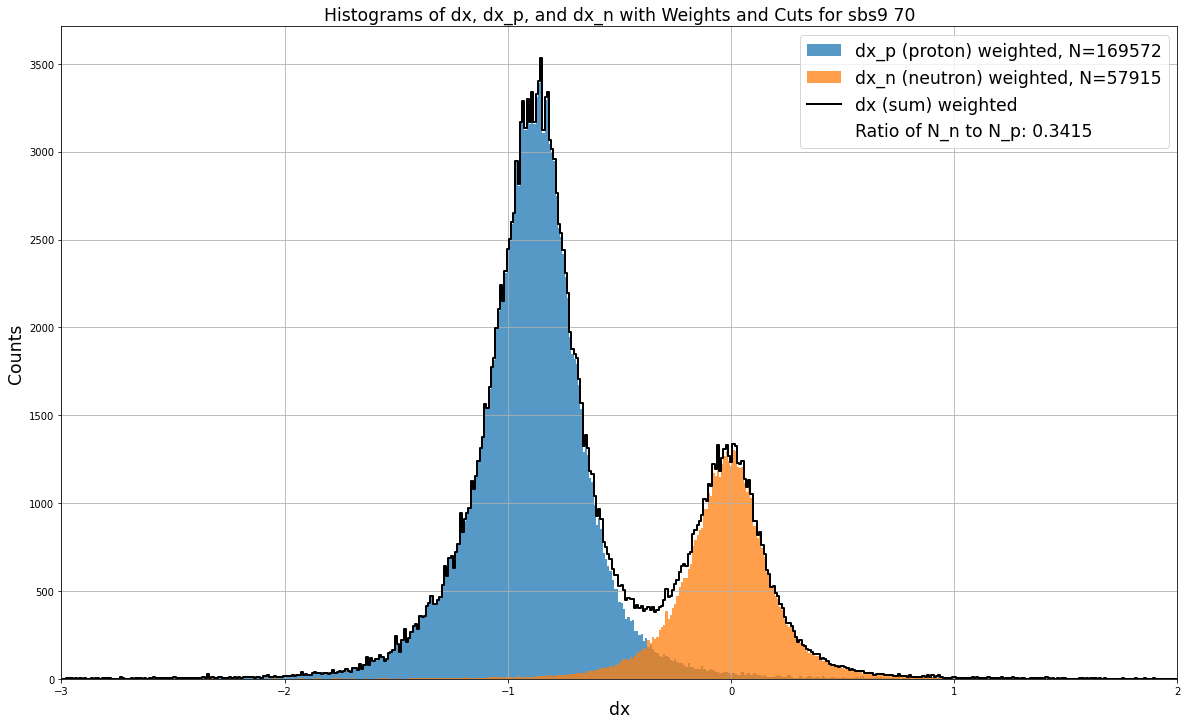

In [6]:
# Loop over the files and plot histograms
for filename in files:
    plot_histogram_from_file(filename)